### Make a non-random baseline for real vs. fake before DeepSonar using the online keyword recognition audio tutorial.

There is actually code for this, and it's not so trivial like a random baseline. I may have implemented DeepSonar wrong...

In [47]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns

In [15]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/training/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000
)
label_names = np.array(train_ds.class_names)

Found 53868 files belonging to 2 classes.


In [16]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [17]:
# convert data to mono (for-norm is mono)
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)

In [18]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


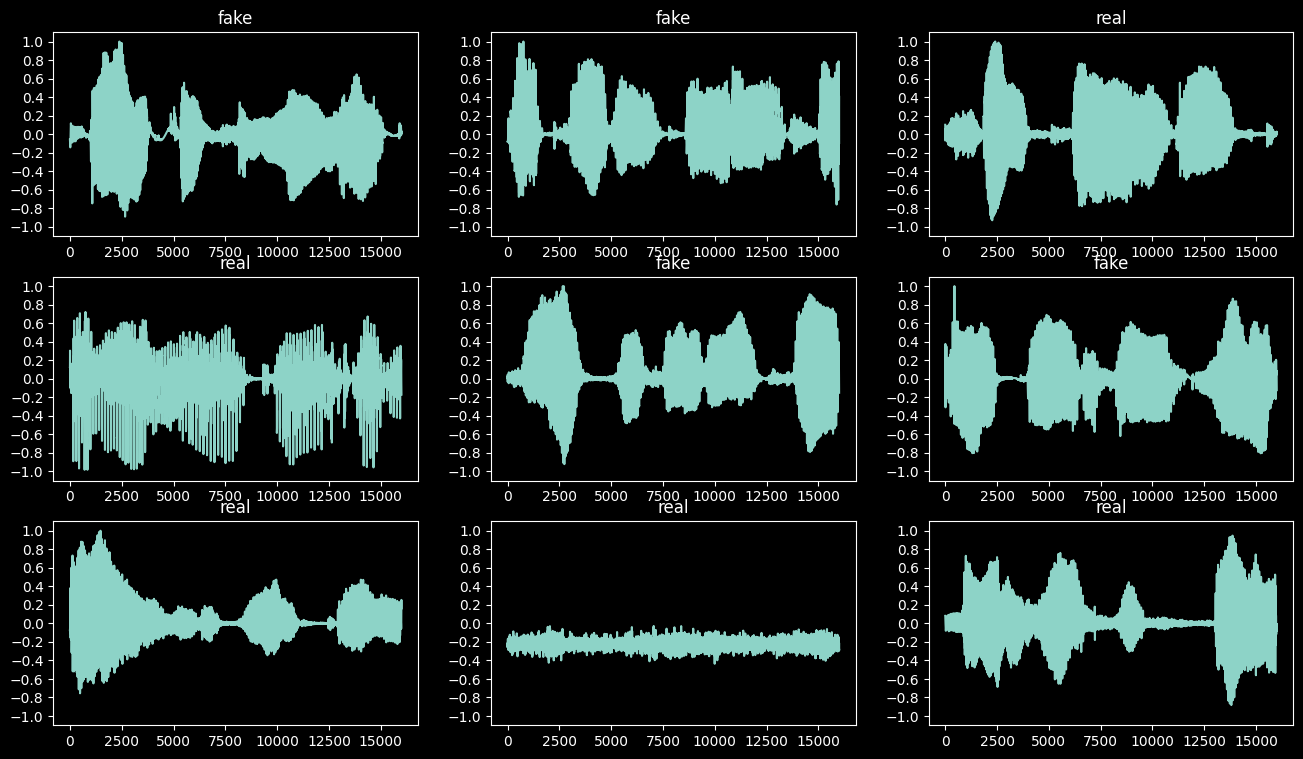

In [19]:
# visualize waveforms
plt.style.use("dark_background")
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

In [20]:
# convert stuff to spectrograms
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)

    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [23]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: fake
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: fake
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: real
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [24]:
def plot_spectrogram(spectrogram, ax):

    # error checking
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

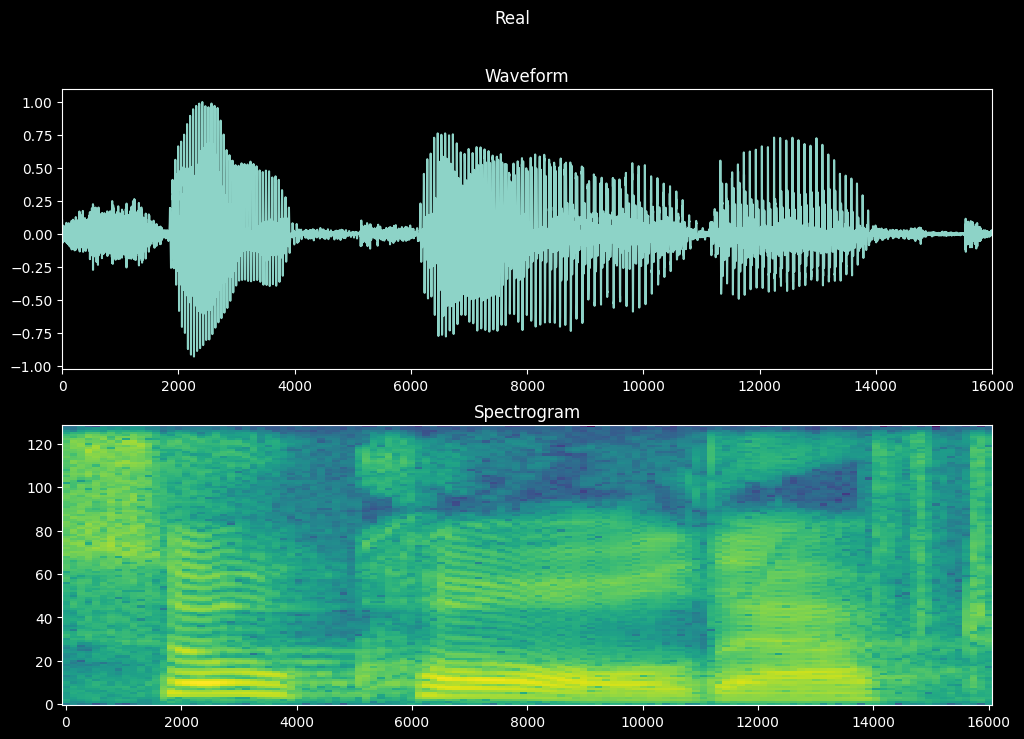

In [25]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [26]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [27]:
train_spectrogram_ds = make_spec_ds(train_ds)

In [28]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [30]:
label_names

array(['fake', 'real'], dtype='<U4')

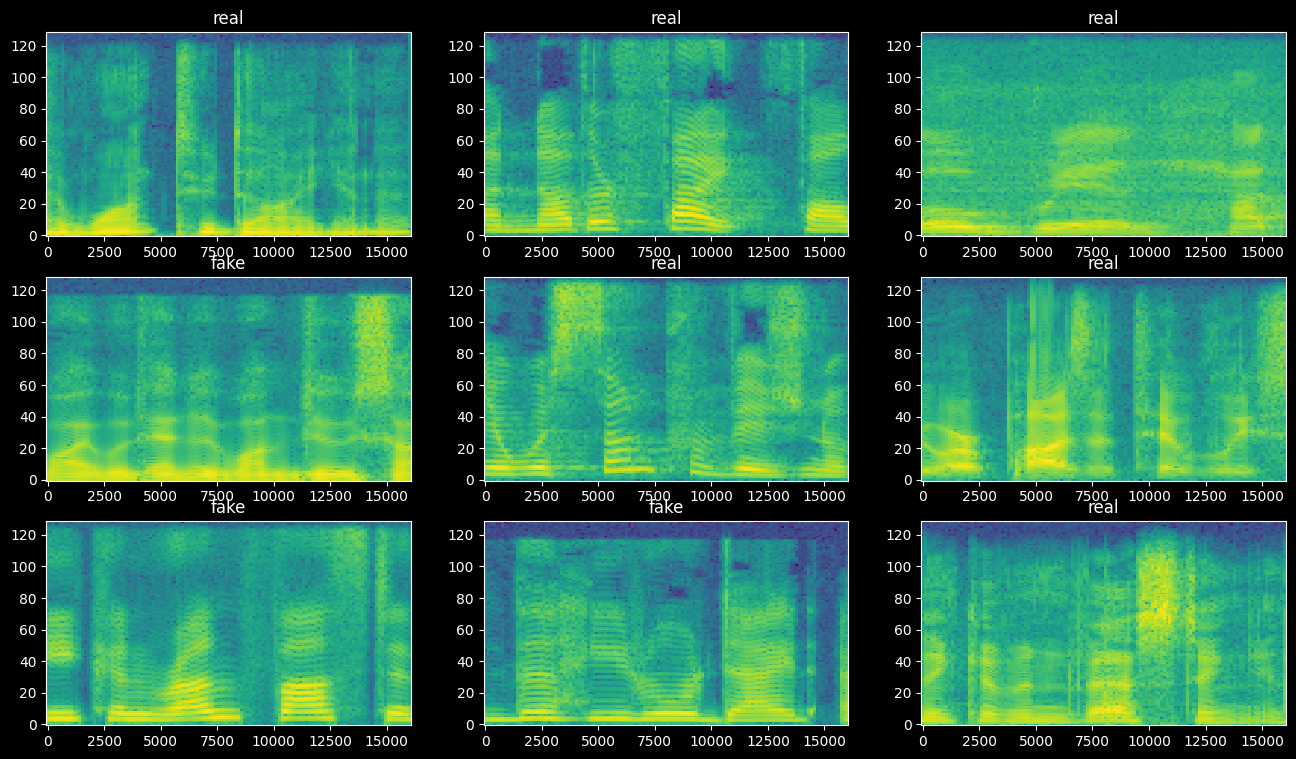

In [32]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [33]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

In [35]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
# need val data
val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/validation/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000
)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
val_spectrogram_ds = make_spec_ds(val_ds)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 10798 files belonging to 2 classes.


In [39]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
842/842 [==============================] - 52s 61ms/step - loss: 0.3557 - accuracy: 0.8325 - val_loss: 0.1655 - val_accuracy: 0.9369
Epoch 2/10
842/842 [==============================] - 44s 52ms/step - loss: 0.1349 - accuracy: 0.9482 - val_loss: 0.0791 - val_accuracy: 0.9716
Epoch 3/10
842/842 [==============================] - 44s 52ms/step - loss: 0.0781 - accuracy: 0.9726 - val_loss: 0.0773 - val_accuracy: 0.9718
Epoch 4/10
842/842 [==============================] - 44s 52ms/step - loss: 0.0601 - accuracy: 0.9785 - val_loss: 0.0431 - val_accuracy: 0.9847
Epoch 5/10
842/842 [==============================] - 44s 52ms/step - loss: 0.0482 - accuracy: 0.9835 - val_loss: 0.0349 - val_accuracy: 0.9884
Epoch 6/10
842/842 [==============================] - 44s 52ms/step - loss: 0.0366 - accuracy: 0.9872 - val_loss: 0.0364 - val_accuracy: 0.9875
Epoch 7/10
842/842 [==============================] - 44s 52ms/step - loss: 0.0323 - accuracy: 0.9886 - val_loss: 0.0299 - val_accuracy:

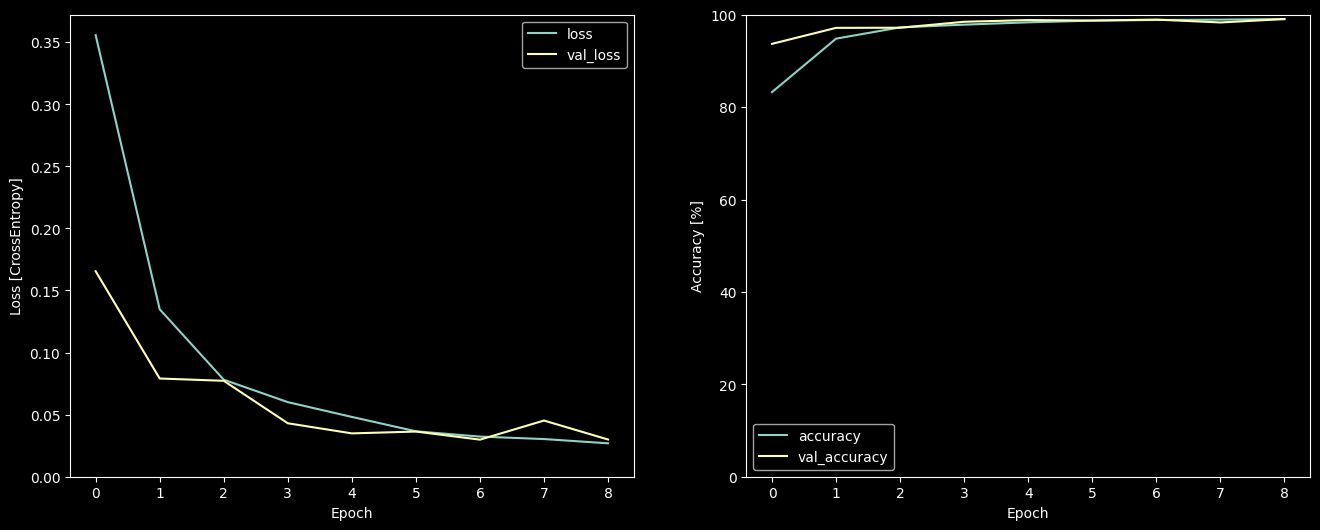

In [40]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy [%]')

In [41]:
# let's see testing stuffs (was much lower on DeepSonar)
# need test dataset
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/testing/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000
)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(test_ds)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 4634 files belonging to 2 classes.


In [42]:
model.evaluate(test_spectrogram_ds, return_dict=True)

73/73 [==============================] - 4s 43ms/step - loss: 0.8220 - accuracy: 0.7954


{'loss': 0.8219771981239319, 'accuracy': 0.7954251170158386}

In [43]:
y_pred = model.predict(test_spectrogram_ds)

73/73 [==============================] - 1s 11ms/step


In [44]:
y_pred = tf.argmax(y_pred, axis=1)

In [45]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

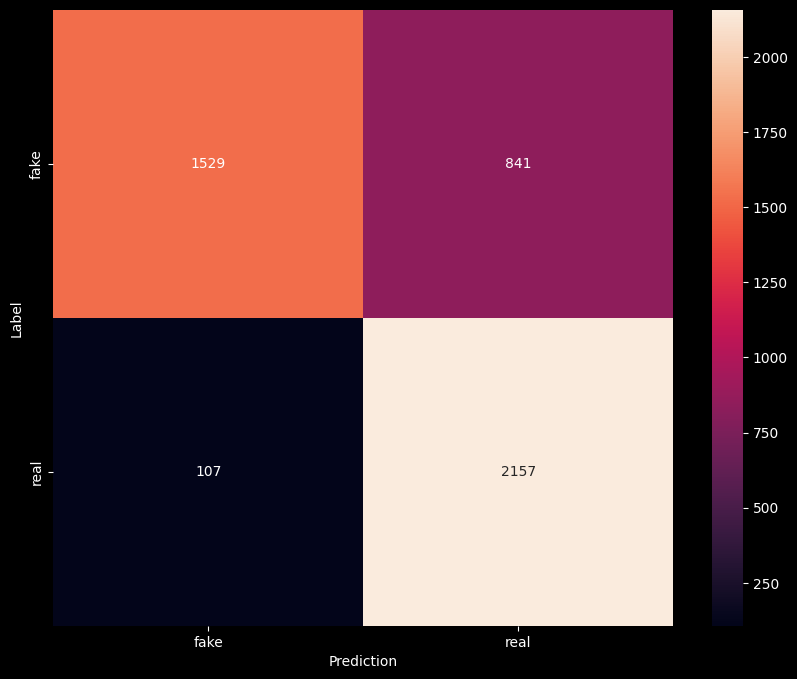

In [48]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Try training DeepSonar, why not?

In [49]:
import sys
sys.path.append("../src/")
from deepsonar_model import get_deepsonar_model

In [84]:
deepsonar = get_deepsonar_model()

successfully loaded model & weights.


In [82]:
deepsonar.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 257, None,   0           []                               
                                1)]                                                               
                                                                                                  
 conv1_1/3x3_s1 (Conv2D)        (None, 257, None, 6  3136        ['input[0][0]']                  
                                4)                                                                
                                                                                                  
 conv1_1/3x3_s1/bn (BatchNormal  (None, 257, None, 6  256        ['conv1_1/3x3_s1[0][0]']         
 ization)                       4)                                                         

In [66]:
deepsonar.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [67]:
EPOCHS = 10
history = deepsonar.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_9" is incompatible with the layer: expected shape=(None, 257, None, 1), found shape=(None, 124, 129, 1)
